# NCAAB 2021 Decision Tree
This is a continuation of my investigation into the 2021 NCAAB [dataset](https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset) to identify markers of success via data anlysis and machine learning. I will be implementing a decision tree classifier that uses many team metrics to predict a wheter or a not a team will make the NCAA tournament, otherwise known as [March Madness](https://www.ncaa.com/news/basketball-men/bracketiq/2023-02-07/what-march-madness-ncaa-tournament-explained). 

## 1) Loading data and libraries
I will use the 2021 season data. We will load those data as well as some useful libraries that we may need throughout.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import tree

In [2]:
#import data and look at head
bb = pd.read_csv('cbb21.csv')
bb.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED
0,Michigan,B10,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,...,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,7.2,1.0
1,Baylor,B12,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,...,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,6.6,1.0
2,Illinois,B10,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,...,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7,8.9,1.0
3,Gonzaga,WCC,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,...,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,8.5,1.0
4,Iowa,B10,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,...,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0,5.6,2.0


## 2) Data pre-processing + investigation
We will now begin modifying our dataset to prepare it for the decision tree classifier. There will be no emphasis on visualization or EDA, as these were previously explored in the [CBB_EDA_2](https://github.com/tjwagner92/ncaab_EDA/blob/main/CBB_EDA_2.ipynb) notebook. 

To start, we will first identify teams that made the tournament as those that do not have a NaN value in the "SEED" column. A team's seed is it's ranking (1-16) in its respective region of the 68-team bracket. Therefore, if this is NaN, it means the team did not receive a March Madness invitation. 

In [3]:
#Mark YES for teams that made the tournament and NO for those that did not
bb['TOURNAMENT'] = np.where(bb['SEED'].notnull(), "YES", "NO")

#look at tail of data to make sure some teams have NO marked for the TOURNAMENT column
bb.tail()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,TOURNAMENT
342,Louisiana Tech,CUSA,27,21,102.7,93.4,0.7479,50.5,45.6,18.4,...,35.3,26.4,49.7,46.4,34.6,29.6,69.6,-1.7,NaN,NO
343,Toledo,MAC,29,21,113.3,101.8,0.7743,54.3,48.3,15.5,...,28.5,23.4,52.5,51.0,37.7,29.5,69.1,-2.1,NaN,NO
344,UAB,CUSA,27,22,102.5,94.6,0.7153,48.6,47.0,15.6,...,29.9,27.1,49.4,46.1,31.1,32.4,67.5,-2.7,NaN,NO
345,Eastern Kentucky,OVC,27,22,101.5,102.3,0.4749,51.2,51.0,16.6,...,25.6,32.2,49.6,51.8,35.8,33.0,75.1,-3.8,NaN,NO
346,Belmont,OVC,29,26,108.5,101.6,0.6786,56.3,49.3,16.6,...,27.9,24.6,59.4,48.2,34.7,34.0,71.1,-1.1,NaN,NO


In [4]:
#Ensure that there are 68 teams with YES for TOURNAMENT
bb['TOURNAMENT'].value_counts()

NO     279
YES     68
Name: TOURNAMENT, dtype: int64

The large imbalance between NO and YES outcomes for the TOURNAMENT is concerning for this model. I am looking into ways to account for this imbalance, but will continue for now with a decision tree based on these data. 

There are some variables that are not necessary to include in our model for now, including the team's seed, its wins above bubble (WAB; wins more than that needed to make tournament), the team name itself, and the conference the team belongs to (CONF). I tried including CONF in the model by using dummy coding and it did not improve the model enough to warrant including it here.

In [5]:
bb.drop(['SEED', 'WAB', 'TEAM', 'CONF'], axis=1, inplace=True)
bb.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,TOURNAMENT
0,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,15.1,29.4,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9,YES
1,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,24.6,37.5,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8,YES
2,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,16.1,33.0,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7,YES
3,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,20.3,30.4,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6,YES
4,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,16.3,30.7,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0,YES


## 3) Model training
Now it is time to split the data into training and testing, and implement a decision tree claissifier on the training data set.

In [6]:
#Separate X and y variables for predictors and target
X = bb.drop(['TOURNAMENT'], axis=1)
y = bb['TOURNAMENT']

#make sure we have excluded the TOURNAMENT variable
X.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T
0,24,20,118.1,91.1,0.9521,54.9,44.9,16.3,15.1,29.4,24.8,28.9,24.5,53.3,42.3,38.7,33.5,66.9
1,24,22,123.2,94.5,0.9548,57.5,49.1,17.6,24.6,37.5,30.9,27.0,31.7,54.1,48.1,41.8,34.0,68.8
2,29,23,117.7,90.4,0.9539,55.6,46.6,18.2,16.1,33.0,22.2,39.2,30.5,55.3,45.4,37.6,32.7,70.7
3,26,26,125.4,89.8,0.9791,61.0,47.5,16.1,20.3,30.4,23.4,36.7,25.9,64.0,46.8,36.5,32.5,74.6
4,29,21,123.5,95.7,0.9491,54.6,48.3,13.3,16.3,30.7,28.6,32.0,22.6,52.4,45.8,38.6,34.8,70.0


In [7]:
#set up the train, test, split function
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [8]:
#train the decision tree
bb_tree = DecisionTreeClassifier()
bb_tree.fit(X_train,y_train)

DecisionTreeClassifier()

## 4) Model testing and diagnostics
The model will now be implemented on the reserved test data, and we will see how its predictions match up with the real outcomes. 

In [9]:
#make predictions on the withheld X_test data
predictions = bb_tree.predict(X_test)

#print the classification report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          NO       0.91      0.94      0.93        54
         YES       0.79      0.69      0.73        16

    accuracy                           0.89        70
   macro avg       0.85      0.82      0.83        70
weighted avg       0.88      0.89      0.88        70



### Some interpretation
We have an unbalanced distribution of outcomes, as noted above, so our accuracy scores are not as reliable an indicator as some of the other diagnostics. Nonetheless, these scores are all quite high given the imbalance. 

Another way of diagnosing model performance is with a confusion matrix, especially when shown as a heatmap such as that below.

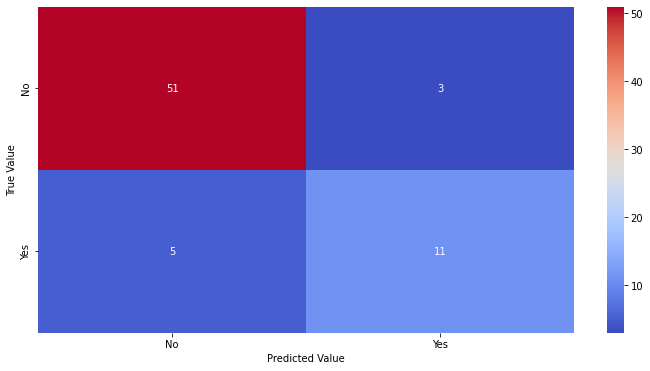

In [10]:
#create the heatmap of the confusion matrix
plt.figure(figsize=(12,6))
ax = sns.heatmap(confusion_matrix(y_test,predictions), annot=True, cmap='coolwarm')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('True Value')
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes']);


### Some interpretation
With this visualization, we see that we had relatively few misclassifications where our prediction did not match the real value of whether or not a team made the March Madness tournament.

Let's visualize what our decision tree actually looks like below.

In [12]:
#make sure we are using the right labels for the tree visualization below
print(bb.columns[:-1])
print('')
print(bb.columns[-1])

Index(['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D', 'TOR', 'TORD',
       'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', '3P_O', '3P_D', 'ADJ_T'],
      dtype='object')

TOURNAMENT


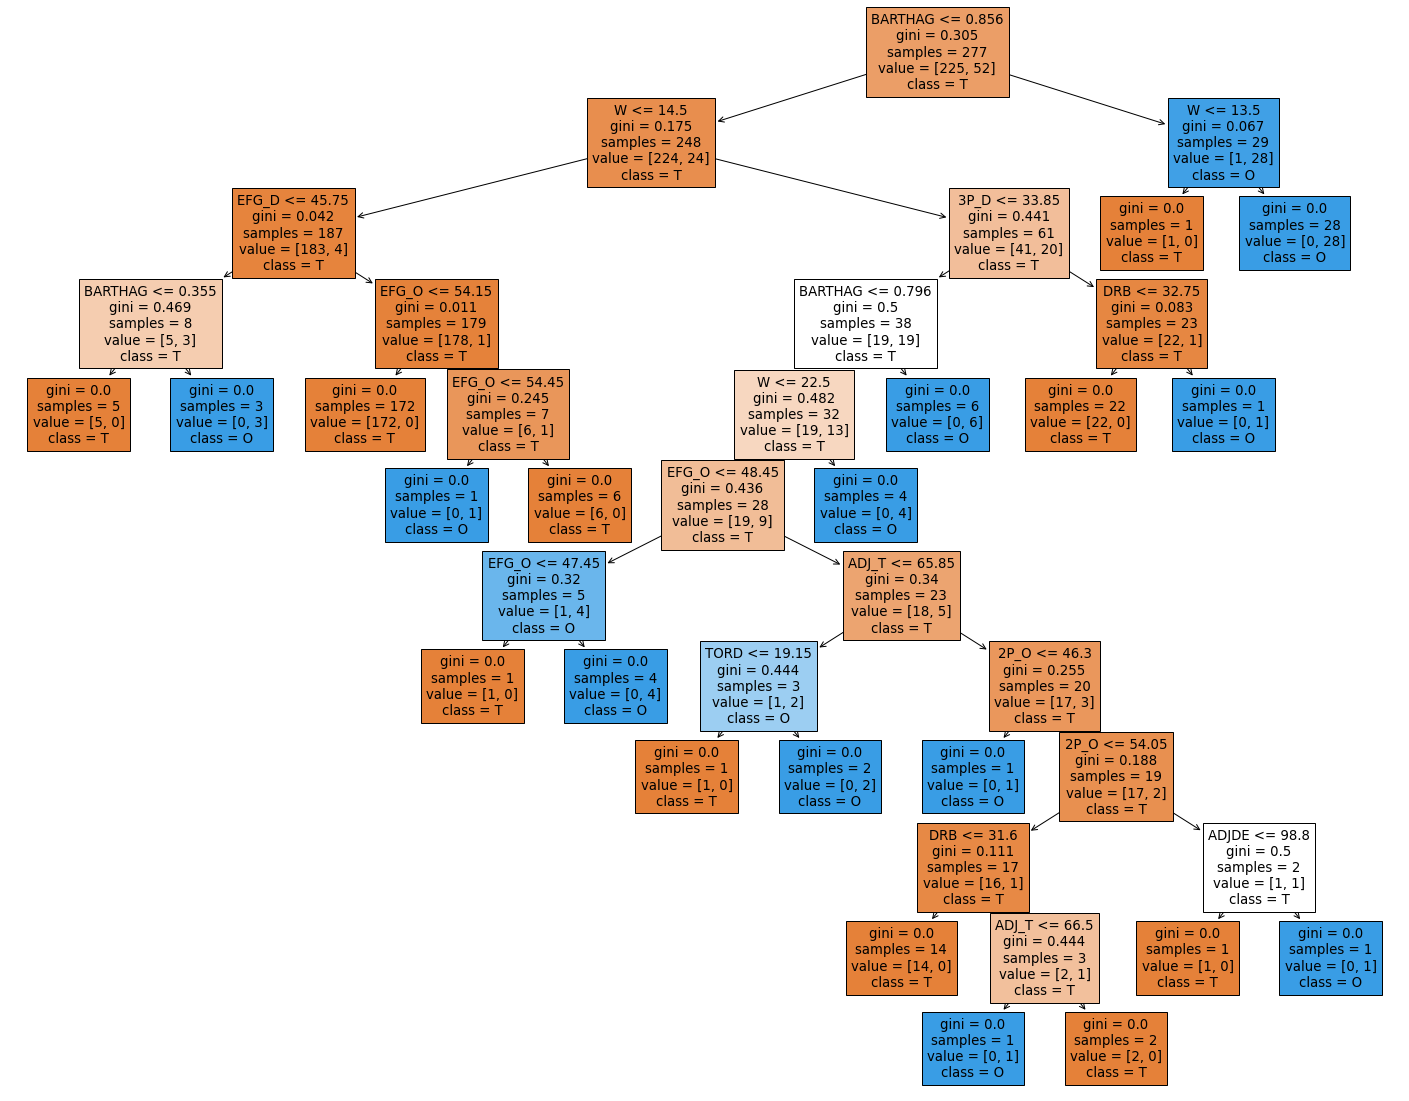

In [13]:
#plot our decision tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(bb_tree, 
                   feature_names=bb.columns[:-1],  
                   class_names=bb.columns[-1],
                   filled=True)

## 5) Model Predictions for previous seasons

Our trained decision tree model for predicting March Madness Tournament participation in the 2021 season can now be used in previosuly unseen datasets. Since the tournament was cancelled in 2020 due to COVID, let's see how it fares on predicting data from 2019. 

In [14]:
#load the 2019 data
bb2 = pd.read_csv('cbb19.csv')
bb2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TEAM        353 non-null    object 
 1   CONF        353 non-null    object 
 2   G           353 non-null    int64  
 3   W           353 non-null    int64  
 4   ADJOE       353 non-null    float64
 5   ADJDE       353 non-null    float64
 6   BARTHAG     353 non-null    float64
 7   EFG_O       353 non-null    float64
 8   EFG_D       353 non-null    float64
 9   TOR         353 non-null    float64
 10  TORD        353 non-null    float64
 11  ORB         353 non-null    float64
 12  DRB         353 non-null    float64
 13  FTR         353 non-null    float64
 14  FTRD        353 non-null    float64
 15  2P_O        353 non-null    float64
 16  2P_D        353 non-null    float64
 17  3P_O        353 non-null    float64
 18  3P_D        353 non-null    float64
 19  ADJ_T       353 non-null    f

In [15]:
#Mark YES for teams that made the tournament and NO for those that did not
bb2['TOURNAMENT'] = np.where(bb2['SEED'].notnull(), "YES", "NO")
bb2.tail()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,TOURNAMENT
348,Alcorn St.,SWAC,27,10,89.0,112.6,0.0628,45.7,52.7,24.1,...,36.5,45.0,55.3,31.3,32.1,67.1,-16.7,NaN,NaN,NO
349,New Hampshire,AE,27,5,83.7,106.1,0.0613,44.0,51.5,18.4,...,38.0,39.4,52.1,32.6,33.6,67.1,-20.2,NaN,NaN,NO
350,Chicago St.,WAC,30,3,88.5,117.3,0.0380,44.2,57.8,22.5,...,33.9,43.5,57.9,30.7,38.5,71.9,-20.9,NaN,NaN,NO
351,Delaware St.,MEAC,29,6,84.3,112.2,0.0358,40.0,52.4,19.0,...,39.2,37.7,52.6,29.0,34.7,71.6,-21.7,NaN,NaN,NO
352,Maryland Eastern Shore,MEAC,30,7,85.7,114.4,0.0346,43.5,54.4,20.7,...,36.6,44.5,53.2,27.9,37.3,64.5,-19.9,NaN,NaN,NO


In [16]:
#Ensure that there are 68 teams with YES for TOURNAMENT
bb2['TOURNAMENT'].value_counts()

NO     285
YES     68
Name: TOURNAMENT, dtype: int64

In [17]:
#set up the test data columns for the 2019 season
X_test_bb2 = bb2.drop(['TEAM', 'CONF', 'SEED', 'WAB', 'POSTSEASON', "TOURNAMENT"], axis=1)
y_test_bb2 = bb2['TOURNAMENT']

X_test_bb2.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T
0,37,33,123.4,89.9,0.9744,59.0,44.2,14.9,19.0,31.5,26.8,35.3,25.9,61.4,43.4,36.3,30.4,72.0
1,38,35,123.0,89.9,0.9736,55.2,44.7,14.7,17.5,30.4,25.4,29.1,26.3,52.5,45.7,39.5,28.9,60.7
2,38,32,118.9,89.2,0.9646,53.6,45.0,17.5,19.4,35.6,29.5,33.2,24.0,58.0,45.0,30.8,29.9,73.6
3,36,29,120.1,91.4,0.9582,52.9,48.9,17.2,18.3,35.3,22.8,30.2,28.4,52.1,47.9,36.2,33.5,76.0
4,37,30,114.6,85.6,0.9665,51.6,44.1,13.9,18.0,24.7,24.8,27.5,24.1,51.8,44.3,34.2,29.1,65.9


In [18]:
#use our previously trained decision tree on these data from 2019
predictions_bb2 = bb_tree.predict(X_test_bb2)

In [19]:
#get classification report and confusion matrux heatmap (below)
print(classification_report(y_test_bb2,predictions_bb2))

              precision    recall  f1-score   support

          NO       0.93      0.85      0.89       285
         YES       0.54      0.75      0.63        68

    accuracy                           0.83       353
   macro avg       0.74      0.80      0.76       353
weighted avg       0.86      0.83      0.84       353



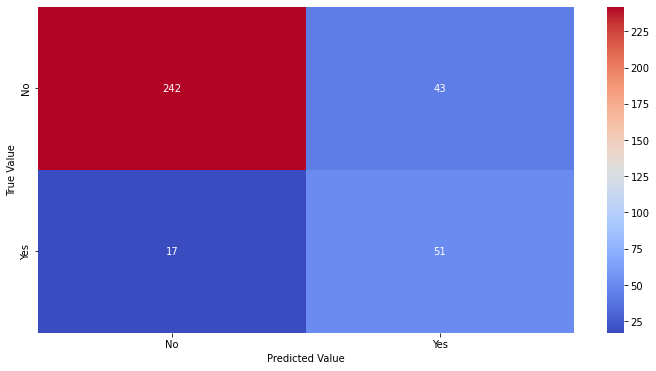

In [20]:
plt.figure(figsize=(12,6))
ax = sns.heatmap(confusion_matrix(y_test_bb2,predictions_bb2), annot=True, fmt = 'g', cmap='coolwarm')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('True Value')
ax.xaxis.set_ticklabels(['No', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes']);


### Interpretation

The decision tree model we trained on the 2021 season data did pretty well on the previously unseen data from the 2019 season as well in terms of predicting which teams made the March Madness tournament.


## 6) Final Summary

1. This notebook builds upon the [CBB_EDA_2](https://github.com/tjwagner92/ncaab_EDA/blob/main/CBB_EDA_2.ipynb) notebook, which used a linear regression model to predict a team's winning percentage based on various team statistics.
2. Using those same statistics from NCAAB teams in the 2021 season, we were able to implement a decision tree model that was fairly accurate at predicting which teams would make the 68-team March Madness tournament.
3. This decision tree model was also accurate in making predictions from the 2019 season, and can likely be generalized to other seasons.
4. As I continue to hone my machine learning skills, I will consider other classification models to find which one can best capture a team's likelihood of making the March Madness tournament.